2. Forecasting. For this problem, use cambridge.csv or cambridge.dta. The file contains
monthly means of daily maximum temperature (variable maxtemp) in Cambridge, from January
1959 up to September 2018. For example, in September 2018, the average maximum daily
temperature in Cambridge was 19.9 degrees of Celsius.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

data = pd.read_stata("cambridge.dta")
print(data.head())
print(data.info())

   year  month  maxtemp          t
0  1959      1      4.4 1959-01-01
1  1959      2      7.5 1959-02-01
2  1959      3     11.5 1959-03-01
3  1959      4     14.3 1959-04-01
4  1959      5     18.1 1959-05-01
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708 entries, 0 to 707
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   year     708 non-null    int16         
 1   month    708 non-null    int8          
 2   maxtemp  708 non-null    float32       
 3   t        708 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float32(1), int16(1), int8(1)
memory usage: 10.5 KB
None


(a) Make a time series plot of maxtemp. Summarize the behavior of these time series. Plot
the correlogram of maxtemp. Comment.



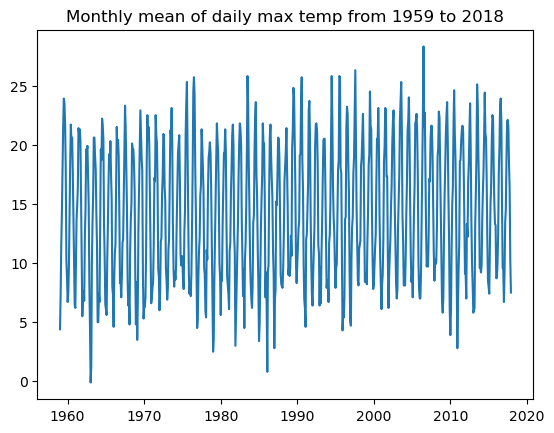

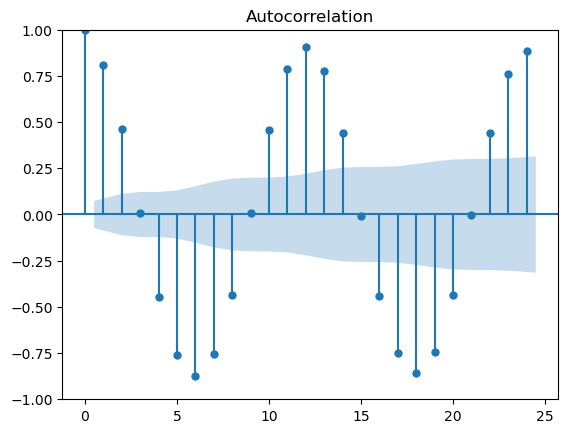

In [2]:

plt.plot(data["t"], data["maxtemp"])
plt.title("Monthly mean of daily max temp from 1959 to 2018")
plt.show()

plot_acf(data["maxtemp"], lags = 24)
plt.show()



(b) Run the regression of maxtemp on the month dummies (don’t fall into the dummy variable
trap!). How would you interpret the coeﬃcients? Save the residuals from this regression
as variable res.

(c) Make a time series plot of res. Any signs of global warming? Plot a correlogram of res.
Comment.


(d) Regress res on variable t, which indexes time, and a constant. Save the residuals as
variable res1. Plot a correlogram of res1. Compare with the correlogram of res. Can
you explain the diﬀerence?

(e) Estimate an AR(1) model for res1. Test hypothesis of no AR(1) serial correlation in the
errors of this model.


(f) Given your estimates in (b-e), what is your forecast of the mean daily maximum temper-
ature in Cambridge in February 2018?
